### with rcp scenario

Year 1900.0: Atmospheric Carbon: 589.00, Terrestrial Carbon: 1875.00, Ocean Mixed Layer Carbon: 900.00, Temperature Anomaly: 0.00, Response Lag: 0.00, System Carbon: 0.00
Year 1902.002002002002: Atmospheric Carbon: 637.33, Terrestrial Carbon: 1873.23, Ocean Mixed Layer Carbon: 892.70, Temperature Anomaly: 0.04, Response Lag: 0.00, System Carbon: 44.36
Year 1904.004004004004: Atmospheric Carbon: 761.11, Terrestrial Carbon: 1875.41, Ocean Mixed Layer Carbon: 809.55, Temperature Anomaly: 0.19, Response Lag: 0.01, System Carbon: 129.92
Initial conditions: [589, 1875, 900, 0, 0, 0]
Final values:
Atmospheric Carbon: 787.7935143977012
Terrestrial Carbon: 1876.0289688241437
Ocean Mixed Layer Carbon: 765.1629285569659
Temperature Anomaly: 0.2133098396728305
Response Lag: 0.006473093055811539
System Carbon: 143.55132338191007


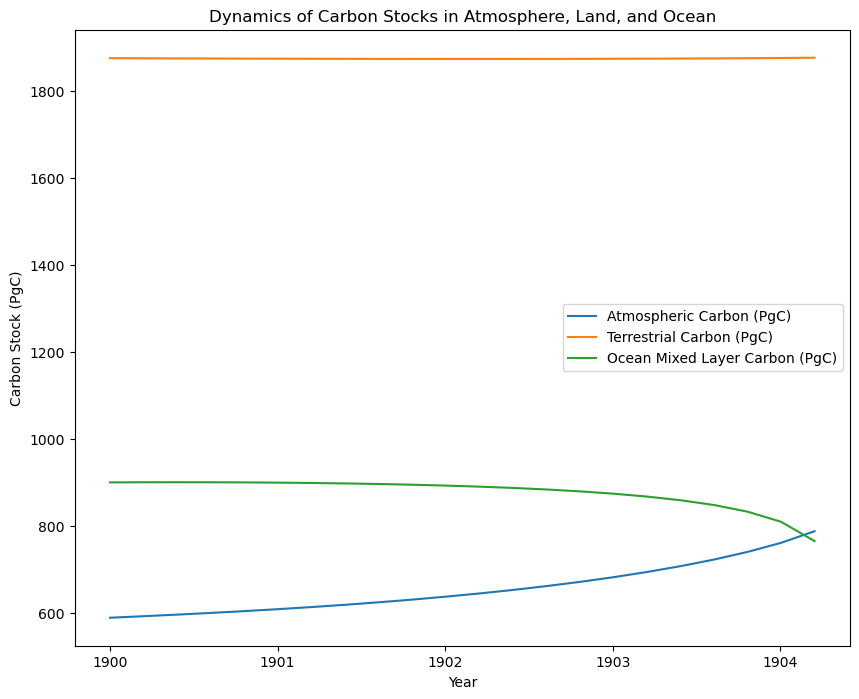

Steady-state values:
Atmospheric Carbon: 585.9318361650576 PgC
Terrestrial Carbon: 482.4339982096867 PgC
Ocean Mixed Layer Carbon: 903.599012444587 PgC
Temperature Anomaly: -0.013398732689863536 °C
Response Lag: -16.601175701826612 °C
System Carbon: -1407.7795980338653 PgC


In [67]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Define the constants and parameters
ca0 = 589  # Pre-industrial atmospheric carbon stock (PgC)
ct0 = 1875  # Pre-industrial terrestrial carbon stock (PgC)
cm0 = 900  # Pre-industrial ocean mixed layer carbon stock (PgC)
NPP0 = 55  # Pre-industrial net primary productivity (PgC/year)
QR = 1.72  # Temperature dependence of respiration
KC = 0.3  # CO2 fertilization effect
KA = 55  # Terrestrial carbon storage loss due to response lag (PgC/K)
rg = 0.025  # Response relaxation rate (year^-1)
vmax = 0.02  # Maximum response rate (°C/year)
pT = 22.5  # Permafrost thaw temperature response (PgC/K)
BTB = 0.7  # Temperature effect on marine biological pump (%/K)
BA = 0.019  # Acidification effect on marine biological pump (%/μatm)
w0 = 0.1  # Solubility pump rate (year^-1)
wT = 0.1  # Weakening of overturning circulation with climate change (%/K)
D = 1  # Atmosphere-ocean CO2 diffusion (year^-1)
r = 12.5  # Revelle factor (buffer factor)
DT = 4.23  # Reduction of solubility with temperature (%/K)
emissions = 0  # Example emissions value
theta = 0.26  # Exponent in biodiversity–function relationship
ICC = 0.05  # Effect of climate change on biodiversity
Id = 0.1  # Direct human impacts on biodiversity
lambda_climate = 1.8  # Transient climate sensitivity (K)
tau = 4  # Climate lag (years)
LUC = 0  # Land-use emissions (PgC/year)

# Initial conditions
T0 = 0  # Initial temperature anomaly (°C)
z0 = 0  # Initial response lag (°C)
ct_init = ct0  # Initial terrestrial carbon stock (PgC)
cm_init = cm0  # Initial ocean mixed layer carbon stock (PgC)
ca_init = ca0  # Initial atmospheric carbon stock (PgC)
cs_init = 0  # Initial change in 'system carbon' (PgC), set to zero as per the paper

# Define the equations
def emissions_RCP(t, scenario="RCP8.5"):
    if scenario == "RCP2.6":
        # Decline to near zero by 2100
        if t <= 20:
            return 9  # Emissions in GtCO₂/year
        elif t <= 40:
            return 9 - (9 / 20) * (t - 20)
        else:
            return 0
    elif scenario == "RCP4.5":
        # Peak around 2040, then decline
        if t <= 40:
            return 11
        elif t <= 76:
            return 11 - (7 / 36) * (t - 40)
        else:
            return 4
    elif scenario == "RCP6.0":
        # Peak around 2080, then decline
        if t <= 60:
            return 17 - (17 / 60) * t
        else:
            return 12 - (12 / 16) * (t - 60)
    elif scenario == "RCP8.5":
        # Continues to rise
        return 10 + (18 / 76) * t
    else:
        raise ValueError("Invalid scenario")

def model(t, y, params):
    ca, ct, cm, T, z, cs = y
    ca0, ct0, cm0, NPP0, QR, KC, KA, rg, vmax, pT, BTB, BA, w0, wT, D, r, DT, emissions, theta, ICC, Id, lambda_climate, tau, LUC, scenario = params
    
    # Response lag equation
    H_delta_T_delta_z = 1  # Placeholder for H(Delta T, Delta z), update this according to the specific form in the paper
    dzdt = vmax * np.tanh(rg * (T - z) / vmax) * H_delta_T_delta_z
    
    # Biodiversity-dependent function
    I = max(0, 1 - ICC * np.abs(T - z) - Id)
    H = I ** theta

    # Terrestrial carbon carrying capacity
    if ca <= 0:
        ca = 1e-6  # Avoid log(0) which is undefined
    K = H * ((1 + KC * np.log(ca / ca0)) * ct0 * QR ** (T / 10) - KA * np.abs(T - z))

    # Terrestrial carbon equation
    dctdt = (NPP0 / ct0) * (QR ** (T / 10)) * (K - ct) - LUC

    # Permafrost carbon emissions
    cp = pT * max(T, 0)
    
    # Ensure cm is positive and not zero
    cm = max(cm, 1e-6)
    
    # Marine biological pump partial pressure
    if 1 - DT * T == 0:
        p_cm = ca0 * (cm / cm0) ** r / 1e-6  # Avoid division by zero
    else:
        p_cm = ca0 * (cm / cm0) ** r / (1 - DT * T)
    
    # Marine biological pump efficiency
    B_0_ca0 = 13 * (1 - 0.032 * 0 - BTB * 0) * (1 - BA * (ca0 - ca0))
    B_DeltaT_p_cm = 13 * (1 - 0.032 * T - BTB * T) * (1 - BA * (p_cm - ca0))
    
    # Ocean mixed layer carbon equation
    dcmdt = (D * cm0 / (p_cm * r / cm0)) * (ca - p_cm) + B_0_ca0 - B_DeltaT_p_cm - w0 * (1 - wT * T) * (cm - cm0)
    
    # Change in system carbon equation
    e_t = emissions_RCP(t, scenario)
    dcsdt = e_t - w0 * (1 - wT * T) * (cm - cm0) - (B_DeltaT_p_cm - B_0_ca0)
    
    # Atmospheric carbon equation based on conservation
    ca_conservation = ca0 + ct0 + cm0 + cs + cp - (ct + cm)
    dca_dt = dcsdt + ca_conservation - ca
    
    # Temperature anomaly equation
    dTdt = (np.log(ca / ca0) * lambda_climate / np.log(2) - T) / tau
    
    return [dca_dt, dctdt, dcmdt, dTdt, dzdt, dcsdt]

# Time vector representing years from 1900 to 2100
t_span = (0, 200)
t_eval = np.linspace(0, 200, 1000)  # 200 years from 1900 to 2100

# Parameter vector
params = (ca0, ct0, cm0, NPP0, QR, KC, KA, rg, vmax, pT, BTB, BA, w0, wT, D, r, DT, emissions, theta, ICC, Id, lambda_climate, tau, LUC, "RCP6.0")

# Initial condition vector
y0 = [ca_init, ct_init, cm_init, T0, z0, cs_init]

# Solve the differential equations using solve_ivp
sol = solve_ivp(model, t_span, y0, args=(params,), method='BDF', t_eval=t_eval, rtol=1e-6, atol=1e-8)

# Extract results
ca_sol, ct_sol, cm_sol, T_sol, z_sol, cs_sol = sol.y
t_sol = sol.t

# Convert the time array from relative (0 to 200) to absolute years (1900 to 2100)
years = t_sol + 1900

# Debugging: Print intermediate values at specific time points
for i, (ca, ct, cm, T, z, cs) in enumerate(zip(ca_sol, ct_sol, cm_sol, T_sol, z_sol, cs_sol)):
    if i % 10== 0:
        print(f"Year {years[i]}: Atmospheric Carbon: {ca:.2f}, Terrestrial Carbon: {ct:.2f}, Ocean Mixed Layer Carbon: {cm:.2f}, Temperature Anomaly: {T:.2f}, Response Lag: {z:.2f}, System Carbon: {cs:.2f}")

# Print final values
print("Initial conditions:", y0)
print("Final values:")
print("Atmospheric Carbon:", ca_sol[-1])
print("Terrestrial Carbon:", ct_sol[-1])
print("Ocean Mixed Layer Carbon:", cm_sol[-1])
print("Temperature Anomaly:", T_sol[-1])
print("Response Lag:", z_sol[-1])
print("System Carbon:", cs_sol[-1])

# Plot the results (focusing on the three main components)
plt.figure(figsize=(10, 8))
plt.plot(years, ca_sol, label='Atmospheric Carbon (PgC)')
plt.plot(years, ct_sol, label='Terrestrial Carbon (PgC)')
plt.plot(years, cm_sol, label='Ocean Mixed Layer Carbon (PgC)')
plt.xlabel('Year')
plt.ylabel('Carbon Stock (PgC)')
plt.legend()
plt.title('Dynamics of Carbon Stocks in Atmosphere, Land, and Ocean')
plt.show()

# Define the function for root finding (steady-state conditions)
def steady_state(y, params):
    return model(0, y, params)

# Initial guess for the solver (same as initial conditions)
y_guess = [ca0, ct0, cm0, T0, z0, cs_init]

# Solve for the steady-state values
steady_state_sol = fsolve(steady_state, y_guess, args=(params,))

# Extract the steady-state values
ca_ss, ct_ss, cm_ss, T_ss, z_ss, cs_ss = steady_state_sol

print(f'Steady-state values:\nAtmospheric Carbon: {ca_ss} PgC\nTerrestrial Carbon: {ct_ss} PgC\n'
      f'Ocean Mixed Layer Carbon: {cm_ss} PgC\nTemperature Anomaly: {T_ss} °C\nResponse Lag: {z_ss} °C\nSystem Carbon: {cs_ss} PgC')
